## Group Work Project GWP1 - Team 3892
The first step of the project is to query the common inputs of the project with S0 = 100; r = 5%; σ = 20%; T = 3 months

# Step 1: Binomial Tree

##Question 5-7:

In [104]:
#Loading the required Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [105]:
#Loading the common inputs of all the model
S0 = 100
R = 0.05
Sigma = 0.2
T = 3/12 #3 months over 1 year period

# European options pricing with binomial tree

In [106]:
# Modify the trinomial tree to binomial tree:
class EuroModel(object):  # Here we start defining our 'class' --> Trinomial Model!
    # First, a method to initialize our `BinomialModel` algorithm!
  def __init__(self, S0, K, r, sigma, T, N, Opttype):
        self.__dt = T/N
        self.__S0 = S0
        self.__K = K
        self.__r = r
        self.__N = N

    # Second, Defining attributes

        self.__u = (np.exp(sigma * np.sqrt(self.__dt)))
        self.__d = (np.exp(-sigma * np.sqrt(self.__dt)))
        self.__p = ((np.exp(r * self.__dt) - self.__d)/(self.__u - self.__d))
        self.__St = np.zeros([N + 1, N + 1])
        self.__option_price = np.zeros([N + 1, N + 1])
        self.__delta = np.zeros([N, N])
        self.__Opttype = Opttype
    # Third, generate a simulation for checking the suitable steps required:
        self.tree = self.tree()

  def tree(self):
      for i in range(0, self.__N + 1):
        if self.__Opttype == "C":
          self.__option_price[self.__N, i] = max(self.__S0 * (self.__u ** (i)) * (self.__d ** (self.__N - i)) - self.__K, 0) #For the Call Options
        else:
          self.__option_price[self.__N, i] = max(self.__K - (self.__S0 * (self.__u ** (i)) * (self.__d ** (self.__N - i))), 0)  # For the Put Options
        self.__St[self.__N, i] = self.__S0 * (self.__u ** (i)) * (self.__d ** (self.__N - i))
      for j in range(self.__N - 1, -1, -1):
          for i in range(0, j + 1):
              self.__option_price[j, i] = np.exp(-self.__r * self.__dt) * (self.__p * self.__option_price[j + 1, i + 1] + (1 - self.__p) * self.__option_price[j + 1, i])
              self.__St[j, i] = self.__S0 * (self.__u ** (i)) * (self.__d ** (j - i))
              self.__delta[j, i] = (self.__option_price[j + 1, i + 1] - self.__option_price[j + 1, i]) / (
                  self.__St[j + 1, i + 1] - self.__St[j + 1, i]
              )
      return self.__option_price[0, 0], self.__option_price, self.__St, self.__delta

    # Four, compute the stock price evolution/compute underlying stock price path
  def stock_evolution(self):
      _, _, evolution, _ = self.tree
      return evolution

    # Fifth, we declare a Payoff method to be completed afterwards depending on the instrument we are pricing!
  def option_price(self):
      option_price, _, _, _ = self.tree
      return option_price

    # Sixth, compute the path delta
  def delta(self):
      _, _, _, delta = self.tree
      return delta

The following section simulate the optimal number of steps required for Call and Put Options accuracy.

4.61


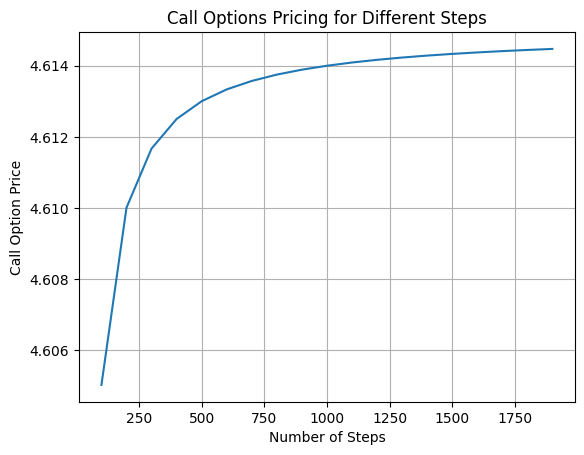

In [107]:
#Identifying the optimal steps for the call options
call_prices = []
n_steps  = []
for i in range(100, 2000, 100):
  call = EuroModel(100, 100, R, Sigma, T, i, "C")
  call_prices.append(call.option_price())
  n_steps.append(i)

print(f'{call.option_price():.2f}') #Represent the option prices in 2 decimal numbers
plt.plot(n_steps, call_prices)
plt.title("Call Options Pricing for Different Steps")
plt.xlabel("Number of Steps")
plt.ylabel("Call Option Price")
plt.grid(True)

3.37


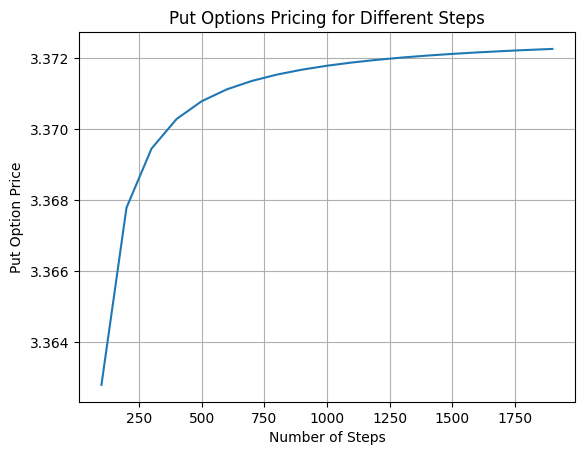

In [108]:
#Identifying the optimal steps for the put options
put_prices = []
n_steps  = []
for i in range(100, 2000, 100):
  put = EuroModel(100, 100, R, Sigma, T, i, "P")
  put_prices.append(put.option_price())
  n_steps.append(i)

print(f'{put.option_price():.2f}')
plt.plot(n_steps, put_prices)
plt.title("Put Options Pricing for Different Steps")
plt.xlabel("Number of Steps")
plt.ylabel("Put Option Price")
plt.grid(True)

Next, we measure the Greek Delta (at time t=0)

In [109]:
# Compute the Greek Delta for the European call and European put at time 0:
call = EuroModel(100, 100, R, Sigma, T, 400, "C")
put = EuroModel(100, 100, R, Sigma, T, 400, "P")

Greek_Delta = pd.DataFrame({"Call Option Price": call.delta()[0,0], "Put Option Price": put.delta()[0,0]}, index = ["Greek Delta at t=0"]).round(2)
Greek_Delta

,Call Option Price,Put Option Price
Greek Delta at t=0,0.57,-0.43


The following part represents the process to measure Vegas, showing how prices of the option will change with respect to the change in volatility.

In [110]:
# Compute the sensitivity of previous put and call option prices to a 5% increase in volatility - sigma (sigma changes from 20% to 25%). How do prices change with respect to the change in volatility?
# Measure the impact of variation in volatility:
callprice_20 = EuroModel(100, 100, R, 0.20, T, 400, "C")
putprice_20 = EuroModel(100, 100, R, 0.20, T, 400, "P")

callprice_25 = EuroModel(100, 100, R, 0.25, T, 400, "C")
putprice_25 = EuroModel(100, 100, R, 0.25, T, 400, "P")

eu_call_binom_vega = (callprice_25.option_price()-callprice_20.option_price())/0.05
eu_put_binom_vega = (putprice_25.option_price()-putprice_20.option_price())/0.05
table_sigchange_20_25 = pd.DataFrame(
    {
        "Call Price Change": [callprice_20.option_price(), callprice_25.option_price(), eu_call_binom_vega],
        "Put Price Change": [putprice_20.option_price(), putprice_25.option_price(), eu_put_binom_vega],
    },
    index = ["20%", "25%", "Vega"]
  ).round(2)

table_sigchange_20_25

,Call Price Change,Put Price Change
20%,4.61,3.37
25%,5.60,4.35
Vega,19.66,19.66


# American options pricing with binomial tree

In [111]:
# Modify the trinomial tree to binomial tree:
class AmericanModel(object):  # Here we start defining our 'class' like it is in the Trinomial Model!
    # First, a method to initialize our `BinomialModel` algorithm!
  def __init__(self, S0, K, r, sigma, T, N, Opttype):
        self.__dt = T/N
        self.__S0 = S0
        self.__K = K
        self.__r = r
        self.__N = N

    # Second, Defining attributes

        self.__u = (np.exp(sigma * np.sqrt(self.__dt)))
        self.__d = (np.exp(-sigma * np.sqrt(self.__dt)))
        self.__p = ((np.exp(r * self.__dt) - self.__d)/(self.__u - self.__d))
        self.__St = np.zeros([N + 1, N + 1])
        self.__option_price = np.zeros([N + 1, N + 1])
        self.__delta = np.zeros([N, N])
        self.__Opttype = Opttype
    # Third, generate a simulation for checking the suitable steps required:
        self.tree = self.tree()

  def tree(self):
      for i in range(0, self.__N + 1):
        if self.__Opttype == "C":
          self.__option_price[self.__N, i] = max(self.__S0 * (self.__u ** (i)) * (self.__d ** (self.__N - i)) - self.__K, 0) #For the Call Options
        else:
          self.__option_price[self.__N, i] = max(self.__K - (self.__S0 * (self.__u ** (i)) * (self.__d ** (self.__N - i))), 0)  # For the Put Options
        self.__St[self.__N, i] = self.__S0 * (self.__u ** (i)) * (self.__d ** (self.__N - i))


      for j in range(self.__N - 1, -1, -1):
          for i in range(0, j + 1):
              self.__option_price[j, i] = np.exp(-self.__r * self.__dt) * (
                  self.__p * self.__option_price[j + 1, i + 1] + (1 - self.__p) * self.__option_price[j + 1, i]
                  )# Computing the European option prices

              self.__St[j, i] = (
                  self.__S0 * (self.__u ** (i)) * (self.__d ** (j - i))
                  )# Underlying evolution for each node

              if self.__Opttype == "C":
                self.__option_price[j, i] = max(
                    self.__option_price[j, i], self.__St[j, i] - self.__K
                ) # Decision between the European option price and the payoff from early-exercise oe American CALL
              else:
                self.__option_price[j, i] = max(
                    self.__option_price[j, i], self.__K - self.__St[j, i]
                ) # Decision between the European option price and the payoff from early-exercise oe American PUTT


              self.__delta[j, i] = (self.__option_price[j + 1, i + 1] - self.__option_price[j + 1, i]) / (
                  self.__St[j + 1, i + 1] - self.__St[j + 1, i]
              )
      return self.__option_price[0, 0], self.__option_price, self.__St, self.__delta


    # Four, compute the stock price evolution/compute underlying stock price path
  def stock_evolution(self):
      _, _, evolution, _ = self.tree
      return evolution

    # Fifth, we declare a Payoff method to be completed afterwards depending on the instrument we are pricing!
  def option_price(self):
      option_price, _, _, _ = self.tree
      return option_price

    # Sixth, compute the path delta
  def delta(self):
      _, _, _, delta = self.tree
      return delta

4.61


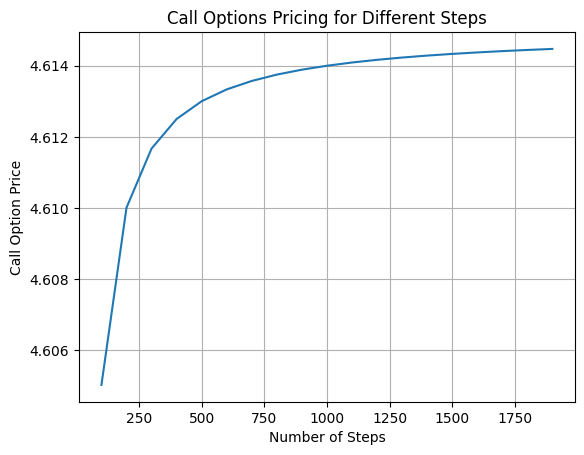

In [112]:
#Identifying the optimal steps for the call options
call_prices = []
n_steps  = []
for i in range(100, 2000, 100):
  call = AmericanModel(100, 100, R, Sigma, T, i, "C")
  call_prices.append(call.option_price())
  n_steps.append(i)

print(f'{call.option_price():.2f}')
plt.plot(n_steps, call_prices)
plt.title("Call Options Pricing for Different Steps")
plt.xlabel("Number of Steps")
plt.ylabel("Call Option Price")
plt.grid(True)

3.48


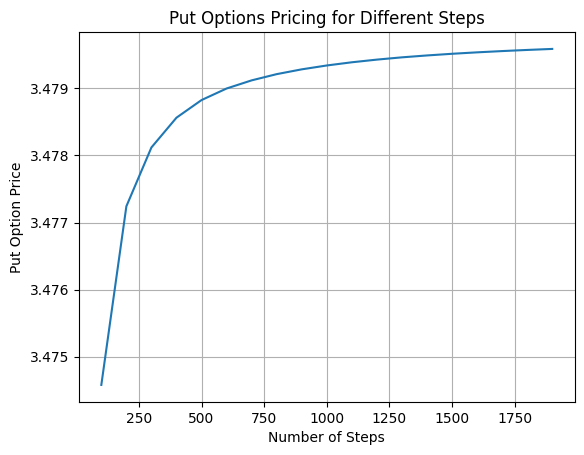

In [113]:
#Identifying the optimal steps for the put options
put_prices = []
n_steps  = []
for i in range(100, 2000, 100):
  put = AmericanModel(100, 100, R, Sigma, T, i, "P")
  put_prices.append(put.option_price())
  n_steps.append(i)

print(f'{put.option_price():.2f}')
plt.plot(n_steps, put_prices)
plt.title("Put Options Pricing for Different Steps")
plt.xlabel("Number of Steps")
plt.ylabel("Put Option Price")
plt.grid(True)

In [114]:
# Compute the Greek Delta for the American call and put at time 0:
call = AmericanModel(100, 100, R, Sigma, T, 400, "C")
put = AmericanModel(100, 100, R, Sigma, T, 400, "P")

Greek_Delta = pd.DataFrame({"Call Option Price": call.delta()[0,0],
                            "Put Option Price": put.delta()[0,0]},
                           index = ["Greek Delta at t=0"]).round(2)
Greek_Delta

,Call Option Price,Put Option Price
Greek Delta at t=0,0.57,-0.45


In [115]:
# Compute the sensitivity of previous put and call option prices to a 5% increase in volatility - sigma (sigma changes from 20% to 25%). How do prices change with respect to the change in volatility?
# Measure the impact of variation in volatility:
callprice_20 = AmericanModel(100, 100, R, 0.20, T, 400, "C")
putprice_20 = AmericanModel(100, 100, R, 0.20, T, 400, "P")

callprice_25 = AmericanModel(100, 100, R, 0.25, T, 400, "C")
putprice_25 = AmericanModel(100, 100, R, 0.25, T, 400, "P")

am_call_binom_vega = (callprice_25.option_price()-callprice_20.option_price())/0.05
am_put_binom_vega = (putprice_25.option_price()-putprice_20.option_price())/0.05
table_sigchange_20_25 = pd.DataFrame(
    {
        "Call Price Change": [callprice_20.option_price(), callprice_25.option_price(), am_call_binom_vega],
        "Put Price Change": [putprice_20.option_price(), putprice_25.option_price(), am_put_binom_vega],
    },
    index = ["20%", "25%", "Vega"]
  ).round(2)

table_sigchange_20_25

,Call Price Change,Put Price Change
20%,4.61,3.48
25%,5.60,4.46
Vega,19.66,19.59


### Question 11-14:

Question 11.

In [116]:
N = 100

def binomial_european_call_option(S0, K, T, r, sigma, N):
    dt = T / N  # time step
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta

    for i in range(0, N + 1):
        C[N, i] = max(S0 * (u ** (i)) * (d ** (N - i)) - K, 0)
        S[N, i] = S0 * (u ** (i)) * (d ** (N - i))

    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S0 * (u ** (i)) * (d ** (j - i))
            Delta[j, i] = (C[j + 1, i + 1] - C[j + 1, i]) / (S[j + 1, i + 1] - S[j + 1, i])

    return C[0, 0], C, S, Delta


def binomial_european_put_option(S0, K, T, r, sigma, N):
    dt = T / N  # time step
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    P = np.zeros([N + 1, N + 1])  # Put prices
    S = np.zeros([N + 1, N + 1])  # Underlying price
    Delta = np.zeros([N, N])  # delta

    for i in range(0, N + 1):
        P[N, i] = max(K - (S0 * (u ** (i)) * (d ** (N - i))), 0)
        S[N, i] = S0 * (u ** (i)) * (d ** (N - i))

    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            P[j, i] = np.exp(-r * dt) * (p * P[j + 1, i + 1] + (1 - p) * P[j + 1, i])
            S[j, i] = S0 * (u ** (i)) * (d ** (j - i))
            Delta[j, i] = (P[j + 1, i + 1] - P[j + 1, i]) / (S[j + 1, i + 1] - S[j + 1, i])

    return P[0, 0], P, S, Delta

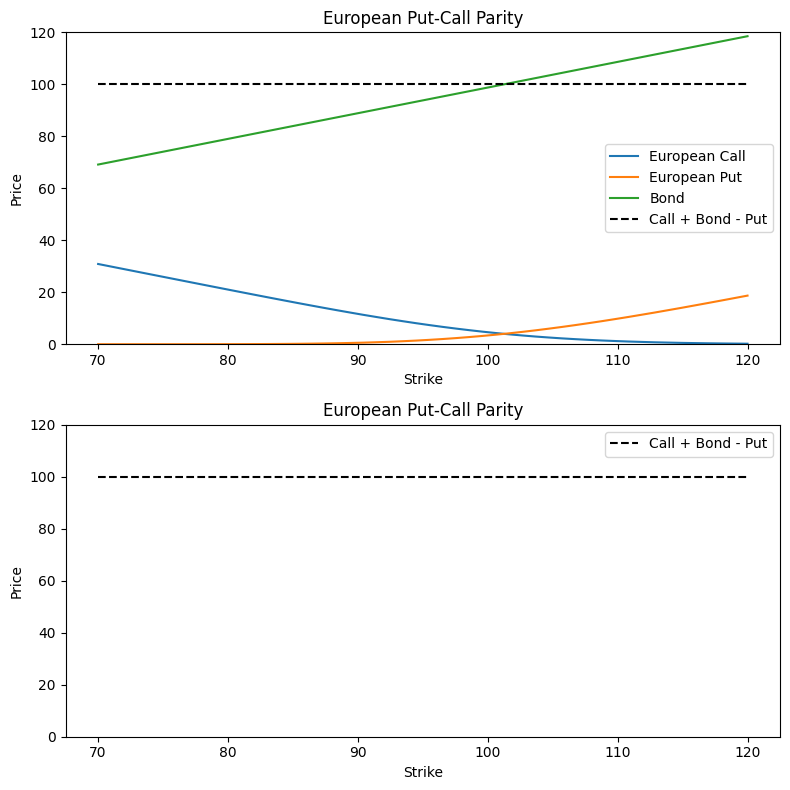

In [117]:
#Loading the common inputs of all the model
S0 = 100
r = 0.05
Sigma = 0.2
T = 3/12 #3 months over 1 year period

K_array = S0 * np.linspace(0.7, 1.2, 50)
eur_call_price_array = np.zeros_like(K_array)
eur_put_price_array = np.zeros_like(K_array)
bond_price_array = np.zeros_like(K_array)

for i, K in enumerate(K_array):
    call_price, call, S, delta = binomial_european_call_option(S0, K, T, r, Sigma, N)
    put_price, put, S, delta = binomial_european_put_option(S0, K, T, r, Sigma, N)
    eur_call_price_array[i] = call_price
    eur_put_price_array[i] = put_price
    bond_price_array[i] = K * np.exp(-r * T)

fig, axs = plt.subplots(nrows=2, figsize=(8, 8))
axs[0].plot(K_array, eur_call_price_array, label='European Call')
axs[0].plot(K_array, eur_put_price_array, label='European Put')
axs[0].plot(K_array, bond_price_array, label='Bond')
axs[0].plot(K_array, eur_call_price_array + bond_price_array - eur_put_price_array, 'k--', label='Call + Bond - Put')
axs[1].plot(K_array, eur_call_price_array + bond_price_array - eur_put_price_array, 'k--', label='Call + Bond - Put')

for ax in axs:
    ax.set_title("European Put-Call Parity")
    ax.set_xlabel("Strike")
    ax.set_ylabel("Price")
    ax.set_ylim(bottom=0, top=max(K_array))
    ax.legend()

plt.tight_layout()
plt.show()

Question 12.

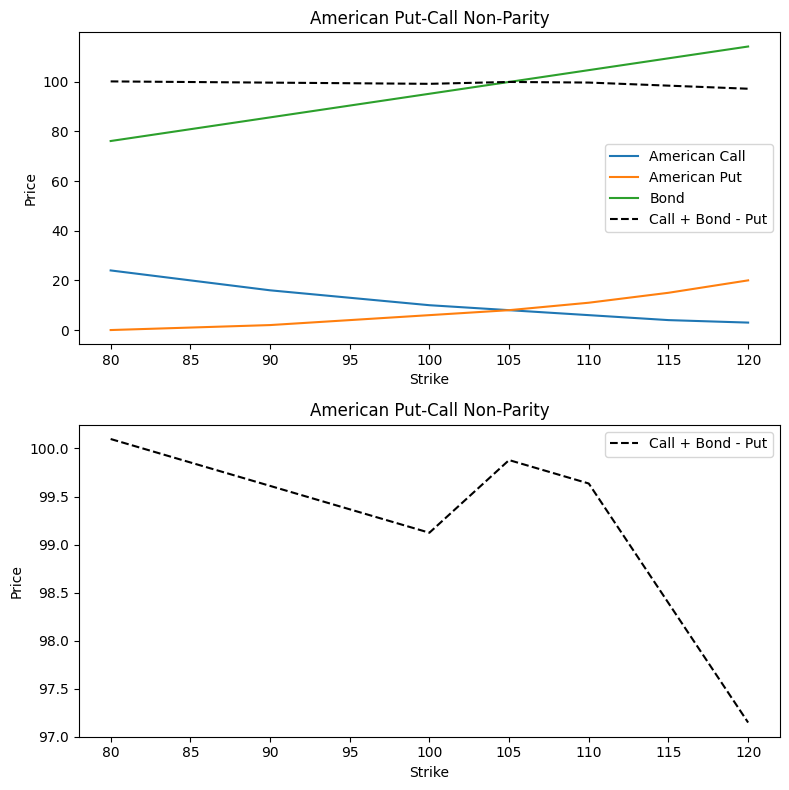

In [118]:
# Parameters
S0 = 100
K_array = np.arange(80, 121, 5)  # Array of strike prices
T = 1
r = 0.05
Sigma = 0.2
N = 300

amr_call_price_array = np.zeros_like(K_array)
amr_put_price_array = np.zeros_like(K_array)

# Calculate option prices for different strike prices
for i, K in enumerate(K_array):
    call = AmericanModel(S0, K, r, Sigma, T, N, "C")
    put = AmericanModel(S0, K, r, Sigma, T, N, "P")
    amr_call_price_array[i] = call.option_price()
    amr_put_price_array[i] = put.option_price()

# Calculate bond price (strike price discounted to present value)
bond_price_array = K_array * np.exp(-r * T)

# Plotting
fig, axs = plt.subplots(nrows=2, figsize=(8, 8))

axs[0].plot(K_array, amr_call_price_array, label='American Call')
axs[0].plot(K_array, amr_put_price_array, label='American Put')
axs[0].plot(K_array, bond_price_array, label='Bond')
axs[0].plot(K_array, amr_call_price_array + bond_price_array - amr_put_price_array, 'k--', label='Call + Bond - Put')

axs[1].plot(K_array, amr_call_price_array + bond_price_array - amr_put_price_array, 'k--', label='Call + Bond - Put')

for ax in axs:
    ax.set_title("American Put-Call Non-Parity")
    ax.set_xlabel("Strike")
    ax.set_ylabel("Price")
    ax.legend()

plt.tight_layout()
plt.show()

Question 13.

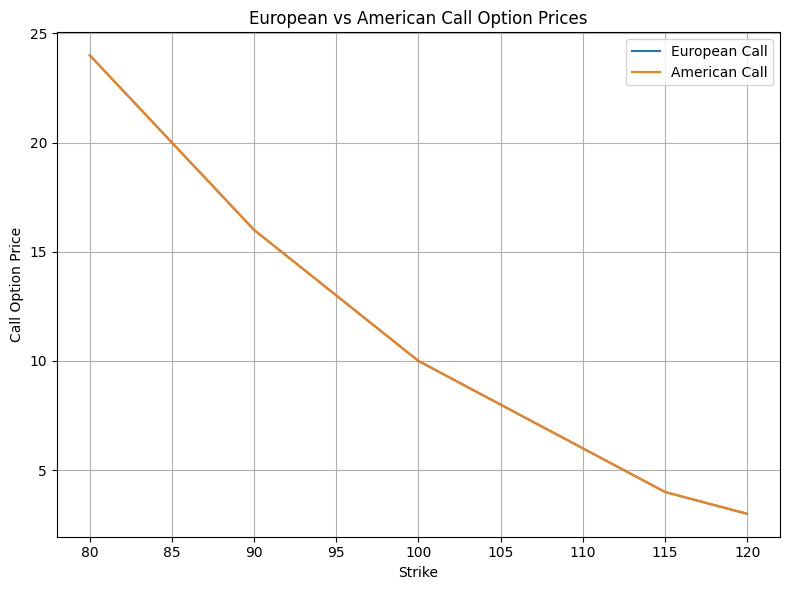

In [119]:
# Parameters
S0 = 100
K_array = np.arange(80, 121, 5)  # Array of strike prices
T = 1
r = 0.05
Sigma = 0.2
N = 300

eur_call_price_array = np.zeros_like(K_array)
amr_call_price_array = np.zeros_like(K_array)

# Calculate option prices for different strike prices
for i, K in enumerate(K_array):
    eur_call = EuroModel(S0, K, r, Sigma, T, N, "C")
    amr_call = AmericanModel(S0, K, r, Sigma, T, N, "C")
    eur_call_price_array[i] = eur_call.option_price()
    amr_call_price_array[i] = amr_call.option_price()

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(K_array, eur_call_price_array, label='European Call')
plt.plot(K_array, amr_call_price_array, label='American Call')
plt.xlabel("Strike")
plt.ylabel("Call Option Price")
plt.title("European vs American Call Option Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Question 14.

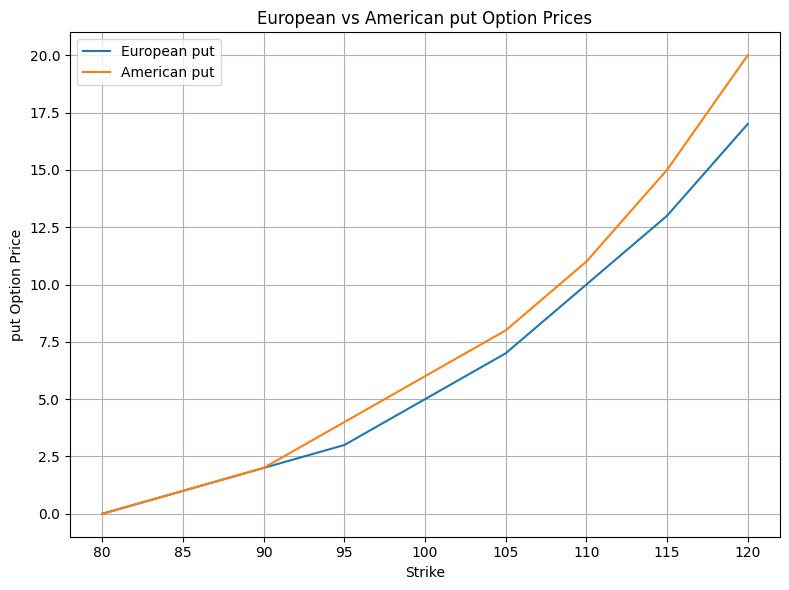

In [120]:
# Parameters
S0 = 100
K_array = np.arange(80, 121, 5)  # Array of strike prices
T = 1
r = 0.05
Sigma = 0.2
N = 300

eur_put_price_array = np.zeros_like(K_array)
amr_put_price_array = np.zeros_like(K_array)

# Calculate option prices for different strike prices
for i, K in enumerate(K_array):
    eur_put = EuroModel(S0, K, r, Sigma, T, N, "P")
    amr_put = AmericanModel(S0, K, r, Sigma, T, N, "P")
    eur_put_price_array[i] = eur_put.option_price()
    amr_put_price_array[i] = amr_put.option_price()

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(K_array, eur_put_price_array, label='European put')
plt.plot(K_array, amr_put_price_array, label='American put')
plt.xlabel("Strike")
plt.ylabel("put Option Price")
plt.title("European vs American put Option Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 2: Trinomial Tree


In [121]:
# Strike prices defined: Deep OTM, OTM, ATM, ITM, and Deep ITM (moneyness of 90%, 95%, ATM, 105%, 110%)
K_90 = 90
K_95 = 95
K_100 = 100
K_105 = 105
K_110 = 110

Here goes the code for trinomial tree for European puts and calls


In [122]:
# Modifyind and reuse some part of the class notes:
class TrinomialModel(object):  # Here we start defining our 'class' --> Trinomial Model!

    # First, a method to initialize our `TrinomialModel` algorithm!
    def __init__(self, S0, r, sigma, mat):
        self.__s0 = S0
        self.__r = r
        self.__sigma = sigma
        self.__T = mat

    # Second, we build a method (function) to compute the risk-neutral probabilities!
    def __compute_probs(self):

        self.__pu = (
            (
                np.exp(self.__r * self.__h / 2)
                - np.exp(-self.__sigma * np.sqrt(self.__h / 2))
            )
            / (
                np.exp(self.__sigma * np.sqrt(self.__h / 2))
                - np.exp(-self.__sigma * np.sqrt(self.__h / 2))
            )
        ) ** 2
        self.__pd = (
            (
                -np.exp(self.__r * self.__h / 2)
                + np.exp(self.__sigma * np.sqrt(self.__h / 2))
            )
            / (
                np.exp(self.__sigma * np.sqrt(self.__h / 2))
                - np.exp(-self.__sigma * np.sqrt(self.__h / 2))
            )
        ) ** 2
        self.__pm = 1 - self.__pu - self.__pd

        assert 0 <= self.__pu <= 1.0, "p_u should lie in [0, 1] given %s" % self.__pu
        assert 0 <= self.__pd <= 1.0, "p_d should lie in [0, 1] given %s" % self.__pd
        assert 0 <= self.__pm <= 1.0, "p_m should lie in [0, 1] given %s" % self.__pm

    # Third, this method checks whether the given parameters are alright and that we have a 'recombining tree'!
    def __check_up_value(self, up):
        if up is None:

            up = np.exp(self.__sigma * np.sqrt(2 * self.__h))

        assert up > 0.0, "up should be non negative"

        down = 1 / up

        assert down < up, "up <= 1. / up = down"

        self.__up = up
        self.__down = down

    # Four, we use this method to compute underlying stock price path
    def __gen_stock_vec(self, nb):
        vec_u = self.__up * np.ones(nb)
        np.cumprod(vec_u, out=vec_u)

        vec_d = self.__down * np.ones(nb)
        np.cumprod(vec_d, out=vec_d)

        res = np.concatenate((vec_d[::-1], [1.0], vec_u))
        res *= self.__s0
        #print(f"Stock Vec{res}")
        return res

    # Fifth, we declare a Payoff method to be completed afterwards depending on the instrument we are pricing!
    def payoff(self, stock_vec):
        raise NotImplementedError()

    # Sixth, compute current prices!
    def compute_current_price(self, crt_vec_stock, nxt_vec_prices):
        #print(f"current price is {nxt_vec_prices}")
        expectation = np.zeros(crt_vec_stock.size)
        for i in range(expectation.size):
            tmp = nxt_vec_prices[i] * self.__pd
            tmp += nxt_vec_prices[i + 1] * self.__pm
            tmp += nxt_vec_prices[i + 2] * self.__pu

            expectation[i] = tmp

        return self.__discount * expectation

    # Seventh, Option pricing!
    def price(self, nb_steps, up=None):
        assert nb_steps > 0, "nb_steps shoud be > 0"

        nb_steps = int(nb_steps)

        self.__h = self.__T / nb_steps
        self.__check_up_value(up)
        self.__compute_probs()

        self.__discount = np.exp(-self.__r * self.__h)

        final_vec_stock = self.__gen_stock_vec(nb_steps)
        final_payoff = self.payoff(final_vec_stock)
        nxt_vec_prices = final_payoff

        for i in range(1, nb_steps + 1):
            vec_stock = self.__gen_stock_vec(nb_steps - i)
            nxt_vec_prices = self.compute_current_price(vec_stock, nxt_vec_prices)

        return nxt_vec_prices[0]

In [123]:
class EuropeanTrinomialCall(TrinomialModel):
    def __init__(self, S0, r, sigma, mat, K):
        super(EuropeanTrinomialCall, self).__init__(S0, r, sigma, mat)
        self.__K = K

    def payoff(self, s):
        return np.maximum(s - self.__K, 0.0)



In [124]:
    def compute_current_price(self, crt_vec_stock, nxt_vec_prices):
        expectation = TrinomialModel.compute_current_price(self, crt_vec_stock, nxt_vec_prices)
        return np.maximum(crt_vec_stock - self.__K, expectation)

    def compute_current_price(self, crt_vec_stock, nxt_vec_prices):
        expectation = TrinomialModel.compute_current_price(self, crt_vec_stock, nxt_vec_prices)
        return np.maximum(self.__K - crt_vec_stock, expectation)

In [125]:
class EuropeanTrinomialPut(TrinomialModel):
    def __init__(self, S0, r, sigma, mat, K):
        super(EuropeanTrinomialPut, self).__init__(S0, r, sigma, mat)
        self.__K = K

    def payoff(self, s):
        return np.maximum(self.__K - s, 0.0)



In [126]:
# European Call Price Valuation with different Stikes ranging from 90% to 110%
eu_call_trinom_K_90 = EuropeanTrinomialCall(S0=S0, K=K_90, mat=T, r=R, sigma=Sigma)
eu_call_trinom_K_95 = EuropeanTrinomialCall(S0=S0, K=K_95, mat=T, r=R, sigma=Sigma)
eu_call_trinom_K_100 = EuropeanTrinomialCall(S0=S0, K=K_100, mat=T, r=R, sigma=Sigma)
eu_call_trinom_K_105 = EuropeanTrinomialCall(S0=S0, K=K_105, mat=T, r=R, sigma=Sigma)
eu_call_trinom_K_110= EuropeanTrinomialCall(S0=S0, K=K_110, mat=T, r=R, sigma=Sigma)

# European Put Price Valuation with different Stikes ranging from 90% to 110%
eu_put_trinom_K_90 = EuropeanTrinomialPut(S0=S0, K=K_90, mat=T, r=R, sigma=Sigma)
eu_put_trinom_K_95 = EuropeanTrinomialPut(S0=S0, K=K_95, mat=T, r=R, sigma=Sigma)
eu_put_trinom_K_100 = EuropeanTrinomialPut(S0=S0, K=K_100, mat=T, r=R, sigma=Sigma)
eu_put_trinom_K_105 = EuropeanTrinomialPut(S0=S0, K=K_105, mat=T, r=R, sigma=Sigma)
eu_put_trinom_K_110= EuropeanTrinomialPut(S0=S0, K=K_110, mat=T, r=R, sigma=Sigma)

In [127]:
pd.DataFrame(
    {
      "European Call Option Price":[X.price(4) for X in [eu_call_trinom_K_90,
                                                eu_call_trinom_K_95,
                                                eu_call_trinom_K_100,
                                                eu_call_trinom_K_105,
                                                eu_call_trinom_K_110]]
    },
   index = ['K = 90', 'K = 95', 'K = 100', 'K = 105', 'K = 110']).round(2)

,European Call Option Price
K = 90,16.80
K = 95,13.50
K = 100,10.21
K = 105,8.19
K = 110,6.18


In [128]:
pd.DataFrame(
    {
    "European Put Option Price": [X.price(4) for X in [eu_put_trinom_K_90,
                                              eu_put_trinom_K_95,
                                              eu_put_trinom_K_100,
                                              eu_put_trinom_K_105,
                                              eu_put_trinom_K_110]]
    },
   index = ['K = 90', 'K = 95', 'K = 100', 'K = 105', 'K = 110']).round(2)

,European Put Option Price
K = 90,2.41
K = 95,3.87
K = 100,5.33
K = 105,8.07
K = 110,10.82


In [129]:
pd.DataFrame(
    {
      "European Call Option Price":[X.price(4) for X in [eu_call_trinom_K_90, eu_call_trinom_K_95, eu_call_trinom_K_100, eu_call_trinom_K_105, eu_call_trinom_K_110]],
      "European Put Option Price": [X.price(4) for X in [eu_put_trinom_K_90, eu_put_trinom_K_95, eu_put_trinom_K_100, eu_put_trinom_K_105, eu_put_trinom_K_110]]
    },
   index = ['K = 90', 'K = 95', 'K = 100', 'K = 105', 'K = 110']).round(2)

,European Call Option Price,European Put Option Price
K = 90,16.80,2.41
K = 95,13.50,3.87
K = 100,10.21,5.33
K = 105,8.19,8.07
K = 110,6.18,10.82


##Question 17-18:
The following stages measure the American Trinomial Option Tree for Call and Put


In [130]:
# Modifyind and reuse some part of the class notes:
class TrinomialModel(object):  # Here we start defining our 'class' --> Trinomial Model!

    # First, a method to initialize our `TrinomialModel` algorithm!
    def __init__(self, S0, r, sigma, mat):
        self.__s0 = S0
        self.__r = r
        self.__sigma = sigma
        self.__T = mat

    # Second, we build a method (function) to compute the risk-neutral probabilities!
    def __compute_probs(self):

        self.__pu = (
            (
                np.exp(self.__r * self.__h / 2)
                - np.exp(-self.__sigma * np.sqrt(self.__h / 2))
            )
            / (
                np.exp(self.__sigma * np.sqrt(self.__h / 2))
                - np.exp(-self.__sigma * np.sqrt(self.__h / 2))
            )
        ) ** 2
        self.__pd = (
            (
                -np.exp(self.__r * self.__h / 2)
                + np.exp(self.__sigma * np.sqrt(self.__h / 2))
            )
            / (
                np.exp(self.__sigma * np.sqrt(self.__h / 2))
                - np.exp(-self.__sigma * np.sqrt(self.__h / 2))
            )
        ) ** 2
        self.__pm = 1 - self.__pu - self.__pd

        assert 0 <= self.__pu <= 1.0, "p_u should lie in [0, 1] given %s" % self.__pu
        assert 0 <= self.__pd <= 1.0, "p_d should lie in [0, 1] given %s" % self.__pd
        assert 0 <= self.__pm <= 1.0, "p_m should lie in [0, 1] given %s" % self.__pm

    # Third, this method checks whether the given parameters are alright and that we have a 'recombining tree'!
    def __check_up_value(self, up):
        if up is None:

            up = np.exp(self.__sigma * np.sqrt(2 * self.__h))

        assert up > 0.0, "up should be non negative"

        down = 1 / up

        assert down < up, "up <= 1. / up = down"

        self.__up = up
        self.__down = down

    # Four, we use this method to compute underlying stock price path
    def __gen_stock_vec(self, nb):
        vec_u = self.__up * np.ones(nb)
        np.cumprod(vec_u, out=vec_u)

        vec_d = self.__down * np.ones(nb)
        np.cumprod(vec_d, out=vec_d)

        res = np.concatenate((vec_d[::-1], [1.0], vec_u))
        res *= self.__s0
        #print(f"Stock Vec{res}")
        return res

    # Fifth, we declare a Payoff method to be completed afterwards depending on the instrument we are pricing!
    def payoff(self, stock_vec):
        raise NotImplementedError()

    # Sixth, compute current prices!
    def compute_current_price(self, crt_vec_stock, nxt_vec_prices):
        #print(f"current price is {nxt_vec_prices}")
        expectation = np.zeros(crt_vec_stock.size)
        for i in range(expectation.size):
            tmp = nxt_vec_prices[i] * self.__pd
            tmp += nxt_vec_prices[i + 1] * self.__pm
            tmp += nxt_vec_prices[i + 2] * self.__pu

            expectation[i] = tmp

        return self.__discount * expectation

    # Seventh, Option pricing!
    def price(self, nb_steps, up=None):
        assert nb_steps > 0, "nb_steps shoud be > 0"

        nb_steps = int(nb_steps)

        self.__h = self.__T / nb_steps
        self.__check_up_value(up)
        self.__compute_probs()

        self.__discount = np.exp(-self.__r * self.__h)

        final_vec_stock = self.__gen_stock_vec(nb_steps)
        final_payoff = self.payoff(final_vec_stock)
        nxt_vec_prices = final_payoff

        for i in range(1, nb_steps + 1):
            vec_stock = self.__gen_stock_vec(nb_steps - i)
            nxt_vec_prices = self.compute_current_price(vec_stock, nxt_vec_prices)

        return nxt_vec_prices[0]

In [131]:
class AmericanTrinomialCall(TrinomialModel):
    def __init__(self, S0, r, sigma, mat, K):
        super(AmericanTrinomialCall, self).__init__(S0, r, sigma, mat)
        self.__K = K

    def payoff(self, s):
        return np.maximum(s - self.__K, 0.0)

    def compute_current_price(self, crt_vec_stock, nxt_vec_prices):
        expectation = TrinomialModel.compute_current_price(self, crt_vec_stock, nxt_vec_prices)
        return np.maximum(crt_vec_stock - self.__K, expectation)

In [132]:
class AmericanTrinomialPut(TrinomialModel):
    def __init__(self, S0, r, sigma, mat, K):
        super(AmericanTrinomialPut, self).__init__(S0, r, sigma, mat)
        self.__K = K

    def payoff(self, s):
        return np.maximum(self.__K - s, 0.0)

    def compute_current_price(self, crt_vec_stock, nxt_vec_prices):
        expectation = TrinomialModel.compute_current_price(self, crt_vec_stock, nxt_vec_prices)
        return np.maximum(self.__K - crt_vec_stock, expectation)

In [133]:
# American Call Price Valuation with different Stikes ranging from 90% tp 110%
ame_call_trinom_K_90 = AmericanTrinomialCall(S0=S0, K=K_90, mat=T, r=R, sigma=Sigma)
ame_call_trinom_K_95 = AmericanTrinomialCall(S0=S0, K=K_95, mat=T, r=R, sigma=Sigma)
ame_call_trinom_K_100 = AmericanTrinomialCall(S0=S0, K=K_100, mat=T, r=R, sigma=Sigma)
ame_call_trinom_K_105 = AmericanTrinomialCall(S0=S0, K=K_105, mat=T, r=R, sigma=Sigma)
ame_call_trinom_K_110= AmericanTrinomialCall(S0=S0, K=K_110, mat=T, r=R, sigma=Sigma)
# Amercian Put Price Valuation with different Stikes ranging from 90% tp 110%
ame_put_trinom_K_90 = AmericanTrinomialPut(S0=S0, K=K_90, mat=T, r=R, sigma=Sigma)
ame_put_trinom_K_95 = AmericanTrinomialPut(S0=S0, K=K_95, mat=T, r=R, sigma=Sigma)
ame_put_trinom_K_100 = AmericanTrinomialPut(S0=S0, K=K_100, mat=T, r=R, sigma=Sigma)
ame_put_trinom_K_105 = AmericanTrinomialPut(S0=S0, K=K_105, mat=T, r=R, sigma=Sigma)
ame_put_trinom_K_110= AmericanTrinomialPut(S0=S0, K=K_110, mat=T, r=R, sigma=Sigma)

In [134]:
pd.DataFrame(
    {
      "American Call Option Price":[X.price(4) for X in [ame_call_trinom_K_90, ame_call_trinom_K_95, ame_call_trinom_K_100, ame_call_trinom_K_105, ame_call_trinom_K_110]]
    },
   index = ['K = 90', 'K = 95', 'K = 100', 'K = 105', 'K = 110']).round(2)

,American Call Option Price
K = 90,16.80
K = 95,13.50
K = 100,10.21
K = 105,8.19
K = 110,6.18


In [135]:
pd.DataFrame(
    {
    "American Put Option Price": [X.price(4) for X in [ame_put_trinom_K_90, ame_put_trinom_K_95, ame_put_trinom_K_100, ame_put_trinom_K_105, ame_put_trinom_K_110]]
    },
   index = ['K = 90', 'K = 95', 'K = 100', 'K = 105', 'K = 110']).round(2)

,American Put Option Price
K = 90,2.54
K = 95,4.02
K = 100,5.85
K = 105,8.84
K = 110,11.83


In [136]:
pd.DataFrame(
    {
      "American Call Option Price":[X.price(4) for X in [ame_call_trinom_K_90, ame_call_trinom_K_95, ame_call_trinom_K_100, ame_call_trinom_K_105, ame_call_trinom_K_110]],
      "American Put Option Price": [X.price(4) for X in [ame_put_trinom_K_90, ame_put_trinom_K_95, ame_put_trinom_K_100, ame_put_trinom_K_105, ame_put_trinom_K_110]]
    },
   index = ['K = 90', 'K = 95', 'K = 100', 'K = 105', 'K = 110']).round(2)

,American Call Option Price,American Put Option Price
K = 90,16.80,2.54
K = 95,13.50,4.02
K = 100,10.21,5.85
K = 105,8.19,8.84
K = 110,6.18,11.83


## Question 19-24:

Question 19.

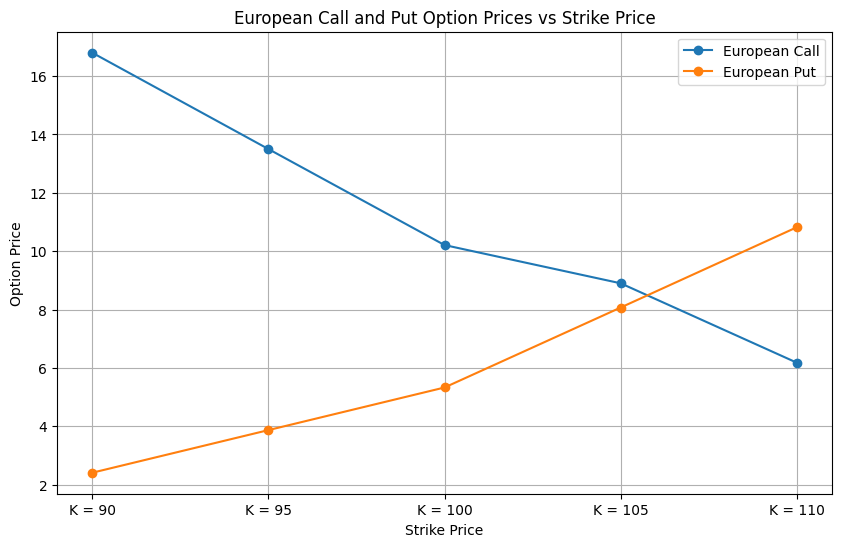

In [137]:
data = {
    "Call Option Price": [16.8, 13.5, 10.21, 8.9, 6.18],
    "Put Option Price": [2.41, 3.87, 5.33, 8.07, 10.82 ]
}

index = ['K = 90', 'K = 95', 'K = 100', 'K = 105', 'K = 110']

df = pd.DataFrame(data, index=index).round(2)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(df.index, df["Call Option Price"], marker='o', label="European Call")
plt.plot(df.index, df["Put Option Price"], marker='o', label="European Put")

plt.title("European Call and Put Option Prices vs Strike Price")
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True)
plt.show()

Question 20.

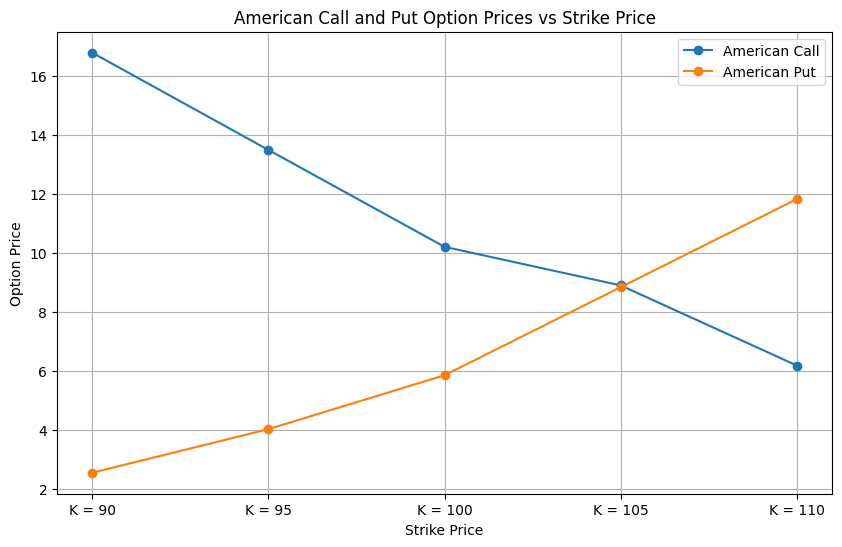

In [138]:
data = {
    "Call Option Price": [16.8, 13.5, 10.21, 8.9, 6.18],
    "Put Option Price": [2.54, 4.02, 5.85, 8.84, 11.83]
}

index = ['K = 90', 'K = 95', 'K = 100', 'K = 105', 'K = 110']

df = pd.DataFrame(data, index=index).round(2)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(df.index, df["Call Option Price"], marker='o', label="American Call")
plt.plot(df.index, df["Put Option Price"], marker='o', label="American Put")

plt.title("American Call and Put Option Prices vs Strike Price")
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True)
plt.show()

Question 21.

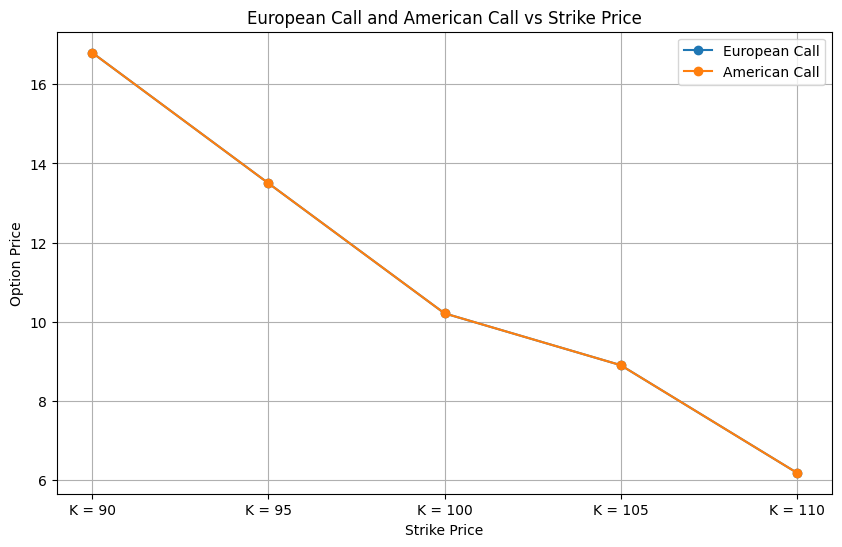

In [139]:
data = {
    "Euro_Call Option Price": [16.8, 13.5, 10.21, 8.9, 6.18],
    "Amer_Call Option Price": [16.8, 13.5, 10.21, 8.9, 6.18]
}

index = ['K = 90', 'K = 95', 'K = 100', 'K = 105', 'K = 110']

df = pd.DataFrame(data, index=index).round(2)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(df.index, df["Euro_Call Option Price"], marker='o', label="European Call")
plt.plot(df.index, df["Amer_Call Option Price"], marker='o', label="American Call")

plt.title("European Call and American Call vs Strike Price")
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True)
plt.show()

Question 22.

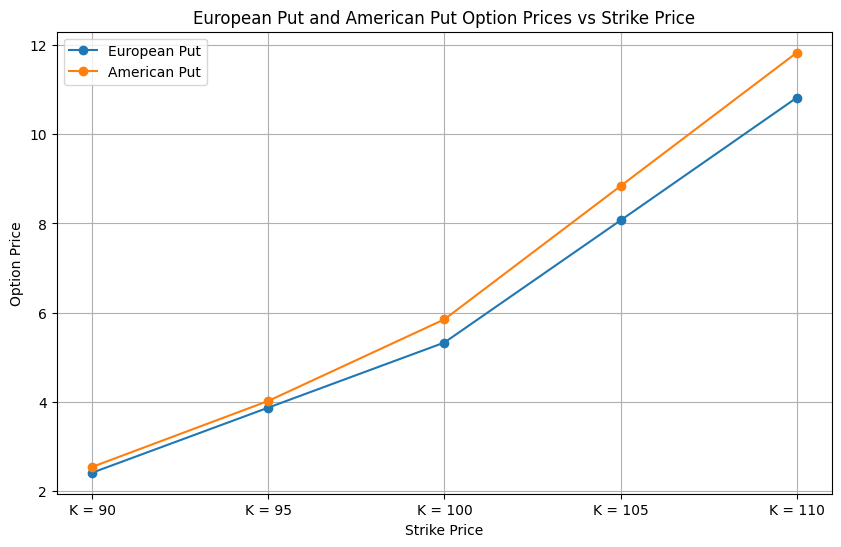

In [140]:
data = {
    "Euro_Put Option Price": [2.41, 3.87, 5.33, 8.07, 10.82],
    "Amer_Put Option Price": [2.54, 4.02, 5.85, 8.84, 11.83]
}

index = ['K = 90', 'K = 95', 'K = 100', 'K = 105', 'K = 110']

df = pd.DataFrame(data, index=index).round(2)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(df.index, df["Euro_Put Option Price"], marker='o', label="European Put")
plt.plot(df.index, df["Amer_Put Option Price"], marker='o', label="American Put")

plt.title("European Put and American Put Option Prices vs Strike Price")
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.legend()
plt.grid(True)
plt.show()

Question 23.

In [141]:
# Define strike prices
K_90 = 90
K_95 = 95
K_100 = 100
K_105 = 105
K_110 = 110

# Modify and reuse the TrinomialModel and other classes as provided

# Create instances of EuropeanTrinomialCall and EuropeanTrinomialPut for each strike
eu_call_trinom_K_90 = EuropeanTrinomialCall(S0=S0, K=K_90, mat=T, r=r, sigma=Sigma)
eu_call_trinom_K_95 = EuropeanTrinomialCall(S0=S0, K=K_95, mat=T, r=r, sigma=Sigma)
eu_call_trinom_K_100 = EuropeanTrinomialCall(S0=S0, K=K_100, mat=T, r=r, sigma=Sigma)
eu_call_trinom_K_105 = EuropeanTrinomialCall(S0=S0, K=K_105, mat=T, r=r, sigma=Sigma)
eu_call_trinom_K_110 = EuropeanTrinomialCall(S0=S0, K=K_110, mat=T, r=r, sigma=Sigma)

eu_put_trinom_K_90 = EuropeanTrinomialPut(S0=S0, K=K_90, mat=T, r=r, sigma=Sigma)
eu_put_trinom_K_95 = EuropeanTrinomialPut(S0=S0, K=K_95, mat=T, r=r, sigma=Sigma)
eu_put_trinom_K_100 = EuropeanTrinomialPut(S0=S0, K=K_100, mat=T, r=r, sigma=Sigma)
eu_put_trinom_K_105 = EuropeanTrinomialPut(S0=S0, K=K_105, mat=T, r=r, sigma=Sigma)
eu_put_trinom_K_110 = EuropeanTrinomialPut(S0=S0, K=K_110, mat=T, r=r, sigma=Sigma)

# Calculate option prices for different strikes
call_prices = [X.price(4) for X in [eu_call_trinom_K_90, eu_call_trinom_K_95, eu_call_trinom_K_100, eu_call_trinom_K_105, eu_call_trinom_K_110]]
put_prices = [X.price(4) for X in [eu_put_trinom_K_90, eu_put_trinom_K_95, eu_put_trinom_K_100, eu_put_trinom_K_105, eu_put_trinom_K_110]]

# Calculate differences between call and put prices
call_put_price_diffs = np.array(call_prices) - np.array(put_prices)

# Calculate differences between stock price and present value of strike price (adjusted for bond price)
stock_strike_diffs = np.array([S0 - K_90, S0 - K_95, S0 - K_100, S0 - K_105, S0 - K_110]) * np.exp(-r * T)

# Check if put-call parity holds within sensible rounding
parities_hold = np.all(np.isclose(call_put_price_diffs, stock_strike_diffs, rtol=1e-2))

print("Put-Call Parity Holds:", parities_hold)

Put-Call Parity Holds: False


Question 24.

In [142]:
# Create instances of AmericanTrinomialCall and AmericanTrinomialPut for each strike
ame_call_trinom_K_90 = AmericanTrinomialCall(S0=S0, K=K_90, mat=T, r=R, sigma=Sigma)
# ... (create instances for other strikes)

ame_put_trinom_K_90 = AmericanTrinomialPut(S0=S0, K=K_90, mat=T, r=R, sigma=Sigma)
# ... (create instances for other strikes)

# Calculate option prices for different strikes
call_prices = [X.price(4) for X in [ame_call_trinom_K_90, ame_call_trinom_K_95, ame_call_trinom_K_100, ame_call_trinom_K_105, ame_call_trinom_K_110]]
put_prices = [X.price(4) for X in [ame_put_trinom_K_90, ame_put_trinom_K_95, ame_put_trinom_K_100, ame_put_trinom_K_105, ame_put_trinom_K_110]]

# Calculate differences between call and put prices
call_put_price_diffs = np.array(call_prices) - np.array(put_prices)

# Create a DataFrame to display the results
result_df = pd.DataFrame(
    {
        "Call Option Price": call_prices,
        "Put Option Price": put_prices,
        "Call-Put Price Difference": call_put_price_diffs
    },
    index=['K = 90', 'K = 95', 'K = 100', 'K = 105', 'K = 110']
)


# Calculate differences between call and put prices
call_put_price_diffs = np.array(call_prices) - np.array(put_prices)

# Calculate differences between stock price and present value of strike price (adjusted for bond price)
stock_strike_diffs = np.array([S0 - K_90, S0 - K_95, S0 - K_100, S0 - K_105, S0 - K_110]) * np.exp(-r * T)

# Check if put-call parity holds within sensible rounding
parities_hold = np.all(np.isclose(call_put_price_diffs, stock_strike_diffs, rtol=1e-2))

print("Put-Call Parity Holds:", parities_hold)

Put-Call Parity Holds: False


#Step 3: Work on the real-world questions:
## Question 25-27
Dynamic Delta Hedging. Use the following data: S0=180, r =2%, sigma=25%, T=6
months, K = 182:

In [143]:
#European Put Price, modifying the code of Chapter 3 for 3-step binomial tree:
S0 = 180
r = 0.02
sigma = 0.25
T = 6/12 #6 months over 12 months
K = 182
N = 3

def european_put_option_delta(S_ini, K, T, r, sigma, N):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta
    for i in range(0, N + 1):
        C[N, i] = max(K - S_ini * (u ** (i)) * (d ** (N - i)), 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            Delta[j, i] = (C[j + 1, i + 1] - C[j + 1, i]) / (
                S[j + 1, i + 1] - S[j + 1, i]
            )
    return C[0, 0], C, S, Delta

In [144]:
C0, C, S, Delta = european_put_option_delta(S0, K, T, r, sigma, N)
pd.DataFrame({'European Put Option Price': [C0]}, index=['']).round(2)

,European Put Option Price
,13.82


In [145]:
#Dynamic Delta Hedging
path = [0, 1, 1, 1]

underlying_stock_price = S[list(range(len(S))), path]
put_option = C[list(range(len(C))), path]
delta_hedge = Delta[list(range(len(Delta))), path[:-1]]
stock_portfolio_value = [underlying_stock_price[0] * delta_hedge[0]] + [0] * N
cash_account = [-stock_portfolio_value[0]] + [0] * N
buy_or_sell = [delta_hedge[0]] + [0] * N

def delta_hedge_fn(underlying_stock_price, put_option, delta_hedge, cash, buy_or_sell):
  for i in range(1, len(stock_portfolio_value)-1):
    buy_or_sell[i] = delta_hedge[i] - delta_hedge[i-1]
    cash[i] = -buy_or_sell[i] * underlying_stock_price[i]
    stock_portfolio_value[i] = stock_portfolio_value[i-1] - cash[i]

  buy_or_sell[N] = -delta_hedge[N-1]
  stock_portfolio_value[N] = delta_hedge[N-1] * underlying_stock_price[N]
  cash[N] = stock_portfolio_value[N] - put_option[N]

  columns=[f't={i}' for i in range(N+1)]

  df = pd.DataFrame([underlying_stock_price, put_option, delta_hedge,stock_portfolio_value, buy_or_sell, cash_account],
                    columns=columns,
                    index=['underlying_stock_price', 'put_option', 'delta_hedge',
                          'stock_portfolio_value', 'buy/sell', 'cash_account'])
  df['Total'] = [np.nan] * 5 + [df.loc['cash_account'].sum()]
  return df.round(2)

delta_hedge_fn(underlying_stock_price, put_option, delta_hedge, cash_account, buy_or_sell)

,t=0,t=1,t=2,t=3,Total
underlying_stock_price,180.00,199.34,180.00,162.54,NaN
put_option,13.82,5.01,9.88,19.46,NaN
delta_hedge,-0.47,-0.24,-0.53,NaN,NaN
stock_portfolio_value,-85.06,-39.17,-90.74,-85.96,NaN
buy/sell,-0.47,0.23,-0.29,0.53,NaN
cash_account,85.06,-45.89,51.57,-105.42,-14.68


In [146]:
pd.DataFrame({'European Put Forward Price': [C0*np.exp(r*T)]}, index=['']).round(2)

,European Put Forward Price
,13.96


In [147]:
# Question 26: Dynamic Delta hedging for American options
N = 25

def american_put_option_delta(S_ini, K, T, r, sigma, N):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta
    for i in range(0, N + 1):
        C[N, i] = max(K - S_ini * (u ** (i)) * (d ** (N - i)), 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            # make it american
            C[j, i] = max(C[j, i], K - S[j, i])
            Delta[j, i] = (C[j + 1, i + 1] - C[j + 1, i]) / (
                S[j + 1, i + 1] - S[j + 1, i]
            )
    return C[0, 0], C, S, Delta

C0, C, S, Delta = american_put_option_delta(S0, K, T, r, sigma, N)
pd.DataFrame({'American_put_price': [C0]}, index=['']).round(2)

,American_put_price
,13.04


In [148]:
path = [0, 0] + [1] * (N-2) + [1]

underplying_stock_price = S[list(range(len(S))), path]
put_option = C[list(range(len(C))), path]
delta_hedge = Delta[list(range(len(Delta))), path[:-1]]
stock_portfolio_value = [underplying_stock_price[0] * delta_hedge[0]] + [0] * N
cash_account = [-stock_portfolio_value[0]] + [0] * N
buy_or_sell = [delta_hedge[0]] + [0] * N

delta_hedge_fn(underplying_stock_price, put_option, delta_hedge, cash_account, buy_or_sell)

,t=0,t=1,t=2,t=3,t=4,t=5,t=6,t=7,t=8,t=9,...,t=17,t=18,t=19,t=20,t=21,t=22,t=23,t=24,t=25,Total
underlying_stock_price,180.00,173.75,180.00,173.75,167.71,161.89,156.26,150.83,145.59,140.54,...,105.91,102.23,98.68,95.26,91.95,88.75,85.67,82.69,79.82,NaN
put_option,13.04,16.05,12.59,15.62,19.09,22.98,27.23,31.79,36.56,41.46,...,76.09,79.77,83.32,86.74,90.05,93.25,96.33,99.31,102.18,NaN
delta_hedge,-0.48,-0.56,-0.48,-0.57,-0.66,-0.75,-0.83,-0.90,-0.96,-0.99,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,NaN,NaN
stock_portfolio_value,-85.60,-100.41,-85.62,-101.07,-116.28,-130.56,-143.26,-153.89,-162.21,-167.35,...,-168.45,-168.45,-168.45,-168.45,-168.45,-168.45,-168.45,-168.45,-79.82,NaN
buy/sell,-0.48,-0.09,0.08,-0.09,-0.09,-0.09,-0.08,-0.07,-0.06,-0.04,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,NaN
cash_account,85.60,14.81,-14.79,15.45,15.21,14.28,12.70,10.63,8.32,5.14,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-182.00,-13.55


In [149]:
pd.DataFrame({'American Put Forward Price': [C0*np.exp(r*T)]}, index=['']).round(2)

,American Put Forward Price
,13.17


In [150]:
## Question 27. Delta hedging for Asian options
N= 25
K = 180

S_ini = S0
dt = T / N  # Define time step
u = np.exp(sigma * np.sqrt(dt))  # Define u
d = np.exp(-sigma * np.sqrt(dt))  # Define d
p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
# C = np.zeros([N + 1, N + 1], 2)  # call prices
S = np.zeros([N + 1, N + 1])  # underlying price
# Delta = np.zeros([N, N])  # delta
for j in range(N, -1, -1):
    for i in range(0, j + 1):
        S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))

import itertools
# third step
paths = [(1, 1, 1), (1, 1, 0), (1, 0, 1), (1, 0, 0), (0, 1, 1), (0, 1, 0), (0, 0, 1), (0, 0, 0)]
path_indices = np.cumsum(np.array(paths), axis=1)
averages = (np.sum(S[[1, 2, 3], path_indices], 1) + S[0,0])/4
# print(f'Averages at the end of the tree: \n\t{averages}')
payoffs = np.maximum(K- averages, 0)
# print(f'Payoffs at the end of the tree: \n\t{payoffs}')

# second step
second_payoffs = []
for i in range(0, len(payoffs), 2):
  second_payoffs.append(np.exp(-r * dt) * (p * payoffs[i] + (1 - p) * payoffs[i+1]))
# print(f'Payoffs at the end second node of the tree: \n\t{second_payoffs}')

# first step
first_payoffs = []
for i in range(0, len(second_payoffs), 2):
  first_payoffs.append(np.exp(-r * dt) * (p * second_payoffs[i] + (1 - p) * second_payoffs[i+1]))
# print(f'Payoffs at the end first node of the tree: \n\t{first_payoffs}')

# zeroth step
C0 = zeroth_payoff = np.exp(-r * dt) * (p * first_payoffs[0] + (1 - p) * first_payoffs[1])
# print(f'Payoffs at the end zeroth node of the tree: \n\t{zeroth_payoff}')

pd.DataFrame([payoffs, second_payoffs, first_payoffs, [zeroth_payoff]], index=['node=3', 'node=2', 'node=1', 'node=0']).round(2)

,0,1,2,3,4,5,6,7
node=3,0.00,0.00,0.00,0.00,0.0,3.13,6.2,9.16
node=2,0.00,0.00,1.57,7.69,NaN,NaN,NaN,NaN
node=1,0.00,4.65,NaN,NaN,NaN,NaN,NaN,NaN
node=0,2.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
# Test with the MC:
def asian_option_put_mc(S_ini, K, T, r, sigma, N, M):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    Asian = np.zeros([M])  # Asian prices
    S = np.zeros([M, N + 1])  # underlying price
    S[:, 0] = S_ini

    for j in range(0, M):
        random = np.random.binomial(1, p, N + 1)
        Total = S_ini
        for i in range(1, N + 1):
            if random[i] == 1:
                S[j, i] = S[j, i - 1] * u
                Total = Total + S[j, i]
            else:
                S[j, i] = S[j, i - 1] * d
                Total = Total + S[j, i]

        Asian[j] = np.exp(-r * T) * max(K-Total / (N + 1), 0)

    return S, Asian

_, Asian = asian_option_put_mc(180, 180, 0.5, 0.02, 0.25, 25, 10000)
pd.DataFrame({'Asian Put Price By Monte Carlo Simulation': np.mean(Asian)}, index=['']).round(2)

,Asian Put Price By Monte Carlo Simulation
,6.7


In [152]:
# Asian Put Delta Heding:

path = [0, 0] + [0] * (N-2) + [1]
stock_price = S[list(range(len(S))), path]
put_option = C[list(range(len(C))), path]
delta_hedge = Delta[list(range(len(Delta))), path[:-1]]
stock_pf_value = [stock_price[0] * delta_hedge[0]] + [0] * N
cash = [-stock_pf_value[0]] + [0] * N
buy_or_sell = [delta_hedge[0]] + [0] * N

delta_hedge_fn(stock_price, put_option, delta_hedge, cash, buy_or_sell)

,t=0,t=1,t=2,t=3,t=4,t=5,t=6,t=7,t=8,t=9,...,t=17,t=18,t=19,t=20,t=21,t=22,t=23,t=24,t=25,Total
underlying_stock_price,180.00,173.75,167.71,161.89,156.26,150.83,145.59,140.54,135.65,130.94,...,98.68,95.26,91.95,88.75,85.67,82.69,79.82,77.05,79.82,NaN
put_option,13.04,16.05,19.48,23.30,27.48,31.96,36.64,41.47,46.35,51.06,...,83.32,86.74,90.05,93.25,96.33,99.31,102.18,104.95,102.18,NaN
delta_hedge,-0.48,-0.56,-0.65,-0.73,-0.81,-0.88,-0.94,-0.98,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,NaN,NaN
stock_portfolio_value,-85.60,-100.41,-115.02,-128.80,-141.20,-151.74,-160.15,-166.38,-168.50,-168.50,...,-168.50,-168.50,-168.50,-168.50,-168.50,-168.50,-168.50,-168.50,-79.82,NaN
buy/sell,-0.48,-0.09,-0.09,-0.09,-0.08,-0.07,-0.06,-0.04,-0.02,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,NaN
cash_account,85.60,14.81,-14.79,15.45,15.21,14.28,12.70,10.63,8.32,5.14,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-182.00,-13.55
